In [4]:
import os
import numpy as np

# Define path to the data files
data_pathA = os.path.join("src", "TrialSuperballistic20frhoA.txt")
data_pathNA = os.path.join("src", "TrialSuperballistic20frhoNA.txt")

# Load data from each file
raw_dataA = np.loadtxt(data_pathA)
raw_dataNA = np.loadtxt(data_pathNA)

# Separate time axis and density matrices
times = raw_dataA[:, 0]  # Assuming time columns are identical

frhoa = raw_dataA
frhona = raw_dataNA


In [13]:
import numpy as np

# Assumptions — set appropriately
ns = 12                     # Number of sites
tmax = times[-1]                # Maximum time
tInterval = times[1] - times[0] # Time step
n_times = len(times)            # Number of time steps

# Construct 2x2 density matrices for A and NA
rhona = []
rhoa = []

for dt in range(n_times):
    rhona_t = []
    rhoa_t = []
    for siteindex in range(ns):
        # Index offsets for each density matrix entry
        p = frhona[dt, 2 + 3 * siteindex]
        re = frhona[dt, 3 + 3 * siteindex]
        im = frhona[dt, 4 + 3 * siteindex]
        rhona_site = np.array([
            [p, re + 1j * im],
            [re - 1j * im, 1 - p]
        ])
        rhona_t.append(rhona_site)

        # Repeat for frhoa
        p_a = frhoa[dt, 2 + 3 * siteindex]
        re_a = frhoa[dt, 3 + 3 * siteindex]
        im_a = frhoa[dt, 4 + 3 * siteindex]
        rhoa_site = np.array([
            [p_a, re_a + 1j * im_a],
            [re_a - 1j * im_a, 1 - p_a]
        ])
        rhoa_t.append(rhoa_site)

    rhona.append(rhona_t)
    rhoa.append(rhoa_t)

# Convert to numpy arrays
rhona = np.array(rhona)  # shape: (n_times, n_sites, 2, 2)
rhoa = np.array(rhoa)

# Reverse time (to match Mathematica's `Table[[Length - n]]`)
rhoNotAligned = rhona[::-1]
rhoAligned = rhoa[::-1]

# Compute Δrho = rhona - rhoa
rhoDelta = rhona - rhoa  # shape: (n_times, n_sites, 2, 2)

# Compute Δρ† Δρ (Frobenius norm squared), then sqrt
rhorhodaggerDelta = np.matmul(np.conj(np.transpose(rhoDelta, (0, 1, 3, 2))), rhoDelta)
# shape: (n_times, n_sites, 2, 2)

# Frobenius norm = sqrt(Tr(Δρ† Δρ)) * 100 * sqrt(2)
FrobeniusNorm = np.sqrt(np.real(np.trace(rhorhodaggerDelta, axis1=2, axis2=3))) / np.sqrt(2)


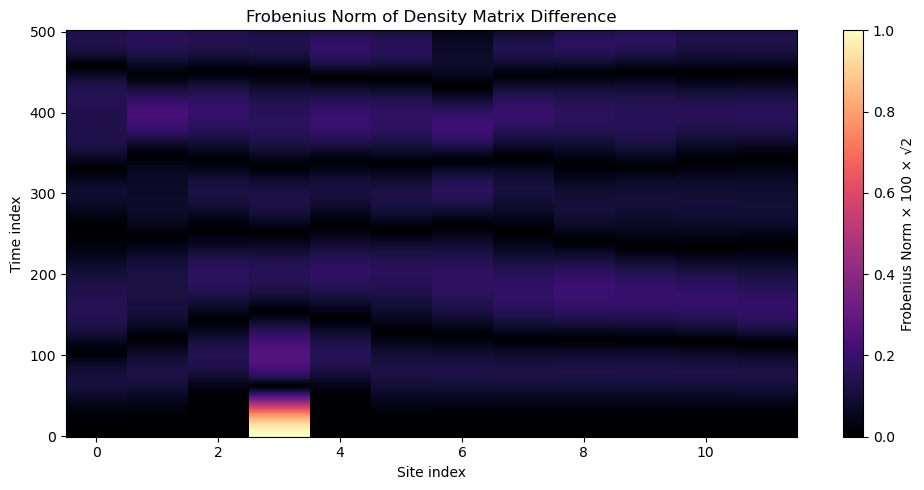

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
im = plt.imshow(FrobeniusNorm, aspect='auto', origin='lower', 
                cmap='magma', interpolation='none')

plt.colorbar(im, label='Frobenius Norm × 100 × √2')
plt.xlabel('Site index')
plt.ylabel('Time index')
plt.title('Frobenius Norm of Density Matrix Difference')
plt.tight_layout()
plt.show()


In [18]:
import numpy as np

threshold = 0.02  # Adjust as needed

arrival_times = []
site_indices = np.arange(FrobeniusNorm.shape[1])

for site in site_indices:
    norm_vs_time = FrobeniusNorm[:, site]
    
    # Find indices where Frobenius norm crosses threshold
    above_thresh = np.where(norm_vs_time > threshold)[0]
    
    if len(above_thresh) > 0:
        # Take the first crossing index as arrival time
        arrival_idx = above_thresh[0]
        arrival_times.append(times[arrival_idx])
    else:
        # No arrival detected; keep NaN to mark missing arrival
        arrival_times.append(np.nan)

arrival_times = np.array(arrival_times)


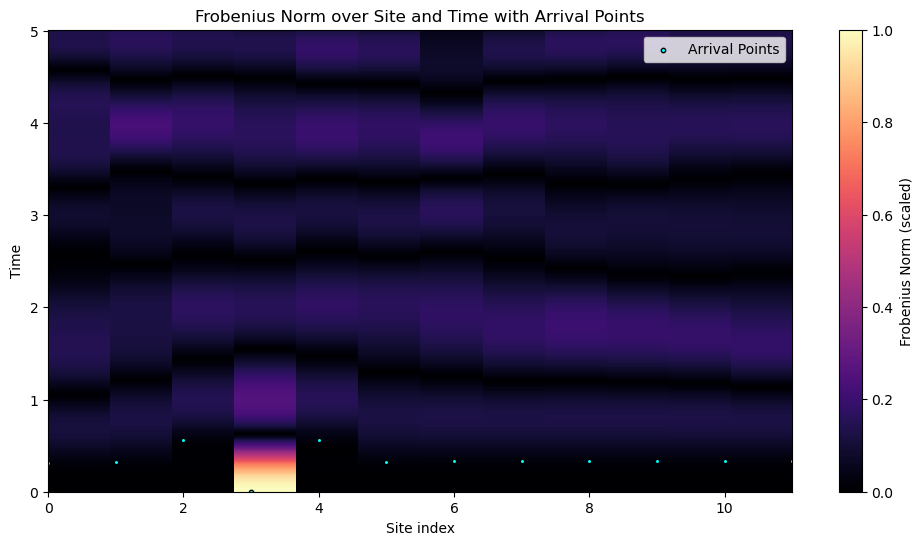

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
im = plt.imshow(FrobeniusNorm, aspect='auto', origin='lower',
                extent=[0, FrobeniusNorm.shape[1]-1, times[0], times[-1]],
                cmap='magma', interpolation='none')
plt.colorbar(im, label='Frobenius Norm (scaled)')
plt.xlabel('Site index')
plt.ylabel('Time')

# Plot arrival points (exclude NaNs)
valid_arrivals = ~np.isnan(arrival_times)
plt.scatter(site_indices[valid_arrivals], arrival_times[valid_arrivals],
            color='cyan', label='Arrival Points', s=10, edgecolors='k')

plt.legend()
plt.title('Frobenius Norm over Site and Time with Arrival Points')
plt.show()
